# OUTLINE:

We have a file in .db format that contains music tracks data.
The business question is not very specific, we just know that initially we have to explore the database using SQL, and then enrich it with the Track and the Authors' Names by using a Spotify API.

After that we can proceed with some general analysis to get some insight such as the top songs and so on.

Let's start.

In [ ]:
# Importing the required libraries

from google.colab import drive
import sqlite3
import pandas as pd
import numpy as np
import json
import requests
from requests.auth import HTTPBasicAuth
!pip install spotipy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import time
import os

In [ ]:
# Connecting the notebook to my Google Drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Creating a variable to store the list of all my files

my_files = []


# Putting the .db file in my Drive and add the filename to the list

my_files.append('spotify_data.db')

In [ ]:
# Function to create filepath automatically from a filename.
def file_path(file_name):
  return f'/content/drive/MyDrive/ONEMEDIA/{file_name}'


database_path = file_path(my_files[-1])

.

Now I will establish 2 SQLite connections. One to the physical .db file and one to an in-memory database. Then I will copy the physical one into the in-memory one.
The reason for this is that the in-memory db is on the ram and it can be updated and changed, not just read.

In [ ]:
# Connect to an in-memory database
memory_conn = sqlite3.connect(':memory:')
cursor = memory_conn.cursor()

In [ ]:
# Connect to the physical database
physical_conn = sqlite3.connect(database_path)

# Generate SQL script to recreate the physical database
sql_script = "".join(line for line in physical_conn.iterdump())

# Execute the script on the in-memory database
memory_conn.executescript(sql_script)

In [ ]:
# Closing the connection to the physical DB. Not needed anymore.
physical_conn.close()

In [ ]:
# Query to find all tables names in the database
tab_names_query = "SELECT name FROM sqlite_master WHERE type='table';"

# Executing the query
cursor.execute(tab_names_query)

# Fetching all results into a list
tables = cursor.fetchall()

# Updating the list so that it contains only the name
tables = [table[0] for table in tables]

# Printing the names of the tables
print('The DB contains these tables:\n')
for table in tables:
    print(table)

The DB contains these tables:

characteristics
charts
ids
release
statistics


Now I will create a python function to launch SQL queries to check tables headers, so I don't need to repeat the same thing 5 times.

In [ ]:
def header_sql(cursor, query):
    cursor.execute(query)

    # Getting column names
    column_names = [description[0] for description in cursor.description]

    # Fetching all rows
    rows = cursor.fetchall()

    # Displaying column names and rows
    print("Column Names:", column_names, "\n")
    for row in rows:
        print(row)

I can start to write in SQL.

In [ ]:
# Checking ids table

query = "SELECT * FROM ids LIMIT 5;"
header_sql(cursor, query)

cursor.execute("SELECT COUNT(*) FROM ids")
lenght = cursor.fetchall()
print("\n Table lenght: ",lenght[0][0])

Column Names: ['id', 'track_id', 'artist_id'] 

(491207958, '6dgUya35uo964z7GZXM07g', '74KM79TiuVKeVCqs8QtB0B')
(556220890, '4d4ZXH4dr5bYfgErHiZCX2', '4q3ewBCX7sLwd24euuV69X')
(204196266, '4vb777iaycnlFxVkJMmtfd', '75VKfyoBlkmrJFDqo1o2VY,6eUKZXaKkcviH0Ku9w2n3V')
(655947751, '5HCyWlXZPP0y6Gqq8TgA20', '2tIP7SsRs7vjIcLrU85W8J,1uNFoZAHBGtllmzznpCI3s')
(806275346, '1BxfuPKGuaTgP7aM0Bbdwr', '06HL4z0CvFAxyc27GXpf02')

 Table lenght:  826


Here I am seeing that some artist has more than one ID. Let's check what is the maximum amont of artist IDs a track has.

In [ ]:
# Checking the max number of IDs

query = '''SELECT MAX(artist_id_count) AS max_artist_ids
FROM (
    SELECT id, track_id,
           LENGTH(artist_id) - LENGTH(REPLACE(artist_id, ',', '')) + 1 AS artist_id_count
    FROM ids
) AS subquery;
'''

cursor.execute(query)
result = cursor.fetchall()

print("The maximun number of artist ID for a track is ", result[0][0])

The maximun number of artist ID for a track is  8


.

In [ ]:
# Counting Tracks Based on Number of Artist IDs

query = '''SELECT
    artist_id_count,
    COUNT(*) as track_count
FROM (
    SELECT
        track_id,
        LENGTH(artist_id) - LENGTH(REPLACE(artist_id, ',', '')) + 1 AS artist_id_count
    FROM ids
) AS subquery
GROUP BY artist_id_count
ORDER BY artist_id_count;
'''

cursor.execute(query)
result = cursor.fetchall()

for num_artists, num_songs in result:
    print(f"{num_artists} Artists: {num_songs} Songs")

1 Artists: 511 Songs
2 Artists: 223 Songs
3 Artists: 70 Songs
4 Artists: 12 Songs
5 Artists: 4 Songs
6 Artists: 3 Songs
7 Artists: 2 Songs
8 Artists: 1 Songs


Since most entries have 1 to 3 artists, I'll split later the artist data into three separate columns and ignore anything after the third artist.

In [ ]:
# Checking release table

query = "SELECT * FROM release LIMIT 5;"
header_sql(cursor, query)

cursor.execute("SELECT COUNT(*) FROM release;")
lenght = cursor.fetchall()
print("\n Table lenght: ",lenght[0][0])

Column Names: ['id', 'released_year', 'released_month', 'released_day'] 

(491207958, 2022, 7, 15)
(556220890, 2022, 5, 6)
(204196266, 2021, 12, 23)
(655947751, 2021, 7, 9)
(806275346, 2019, 8, 23)

 Table lenght:  826


Note: "release" is a locked word in some SQL dialects like mySQL. Here in SQLite it works without commas but one should be paying attention to such things.

In [ ]:
# Checking charts table

query = "SELECT * FROM charts LIMIT 5;"
header_sql(cursor, query)

cursor.execute("SELECT COUNT(*) FROM charts;")
lenght = cursor.fetchall()
print("\n Table lenght: ",lenght[0][0])

Column Names: ['id', 'in_spotify_playlists', 'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts', 'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts'] 

(491207958, 2346, 27, '342897938', 69, 12, '38', 8, '64')
(556220890, 892, 3, '338422004', 10, 24, '11', 0, '0')
(204196266, 2999, 0, '261286503', 60, 17, '154', 0, '22')
(655947751, 17050, 36, '2665343922', 492, 99, '798', 31, '0')
(806275346, 7858, 100, '800840817', 116, 207, '125', 12, '548')

 Table lenght:  826


In [ ]:
# Checking characteristics table

query = "SELECT * FROM characteristics LIMIT 5;"
header_sql(cursor, query)

cursor.execute("SELECT COUNT(*) FROM characteristics;")
lenght = cursor.fetchall()
print("\n Table lenght: ",lenght[0][0])

Column Names: ['id', 'bpm', 'key', 'mode'] 

(491207958, 139, 'G#', 'Major')
(556220890, 130, 'C#', 'Major')
(204196266, 108, 'G', 'Minor')
(655947751, 170, 'C#', 'Major')
(806275346, 170, 'A', 'Major')

 Table lenght:  826


In [ ]:
# Checking statistics table

query = "SELECT * FROM statistics LIMIT 5;"
header_sql(cursor, query)

cursor.execute("SELECT COUNT(*) FROM statistics;")
lenght = cursor.fetchall()
print("\n Table lenght: ",lenght[0][0])

Column Names: ['id', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%'] 

(491207958, 74, 68, 68, 3, 0, 26, 4)
(556220890, 82, 50, 67, 12, 0, 13, 5)
(204196266, 96, 71, 42, 57, 0, 8, 9)
(655947751, 59, 48, 76, 4, 0, 10, 5)
(806275346, 55, 58, 72, 11, 0, 11, 15)

 Table lenght:  826


.

.

I know already that the columns I need to use for the JOIN don't have any issues, so I will procede to create the joined table and will handle the other columns later.

In [ ]:
# SQL query to join my tables

join_query = """
CREATE TABLE joined AS
SELECT
    ids.track_id,
    ids.artist_id,
    release.released_year,
    release.released_month,
    release.released_day,
    charts.in_spotify_playlists,
    charts.in_spotify_charts,
    charts.streams,
    charts.in_apple_playlists,
    charts.in_apple_charts,
    charts.in_deezer_playlists,
    charts.in_deezer_charts,
    charts.in_shazam_charts,
    characteristics.bpm,
    characteristics.key,
    characteristics.mode,
    statistics."danceability_%",
    statistics."valence_%",
    statistics."energy_%",
    statistics."acousticness_%",
    statistics."instrumentalness_%",
    statistics."liveness_%",
    statistics."speechiness_%"
FROM ids
LEFT JOIN release ON ids.id = release.id
LEFT JOIN charts ON ids.id = charts.id
LEFT JOIN characteristics ON ids.id = characteristics.id
LEFT JOIN statistics ON ids.id = statistics.id;
"""

Note: I had to use quotes for column names that contained the % sign.

.

In [ ]:
# Executing the query
cursor.execute(join_query)

# Commit the changes
memory_conn.commit()

In [ ]:
cursor.execute("PRAGMA table_info(joined);")
result = cursor.fetchall()
result

[(0, 'track_id', 'TEXT', 0, None, 0),
 (1, 'artist_id', 'TEXT', 0, None, 0),
 (2, 'released_year', 'INT', 0, None, 0),
 (3, 'released_month', 'INT', 0, None, 0),
 (4, 'released_day', 'INT', 0, None, 0),
 (5, 'in_spotify_playlists', 'INT', 0, None, 0),
 (6, 'in_spotify_charts', 'INT', 0, None, 0),
 (7, 'streams', 'TEXT', 0, None, 0),
 (8, 'in_apple_playlists', 'INT', 0, None, 0),
 (9, 'in_apple_charts', 'INT', 0, None, 0),
 (10, 'in_deezer_playlists', 'TEXT', 0, None, 0),
 (11, 'in_deezer_charts', 'INT', 0, None, 0),
 (12, 'in_shazam_charts', 'TEXT', 0, None, 0),
 (13, 'bpm', 'INT', 0, None, 0),
 (14, 'key', 'TEXT', 0, None, 0),
 (15, 'mode', 'TEXT', 0, None, 0),
 (16, 'danceability_%', 'INT', 0, None, 0),
 (17, 'valence_%', 'INT', 0, None, 0),
 (18, 'energy_%', 'INT', 0, None, 0),
 (19, 'acousticness_%', 'INT', 0, None, 0),
 (20, 'instrumentalness_%', 'INT', 0, None, 0),
 (21, 'liveness_%', 'INT', 0, None, 0),
 (22, 'speechiness_%', 'INT', 0, None, 0)]

.

Now I can save the result of this query into a CSV file and get rid of the SQLite connection. From now on I will work with Pandas on the resulting Dataframe called "df".

In [ ]:
query = "SELECT * FROM joined;"

# Read the query results into a pandas DataFrame
df = pd.read_sql_query(query, memory_conn)

# Creating a new file name for the joined csv
my_files.append('joined_csv.csv')

# Downloading the df into CSV
df.to_csv(file_path(my_files[-1]), index=False)

# Closing the in memory connection
memory_conn.close()

print(f"Data saved to CSV at {file_path(my_files[-1])}")

Data saved to CSV at /content/drive/MyDrive/ONEMEDIA/joined_csv.csv


.


.

Now I will check the pandas dataframe, split the artist_id column and collect additional info from the API

In [ ]:
# Checking the DF

df.head(5)

,track_id,artist_id,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,6dgUya35uo964z7GZXM07g,74KM79TiuVKeVCqs8QtB0B,2022,7,15,2346,27,342897938,69,12,...,139,G#,Major,74,68,68,3,0,26,4
1,4d4ZXH4dr5bYfgErHiZCX2,4q3ewBCX7sLwd24euuV69X,2022,5,6,892,3,338422004,10,24,...,130,C#,Major,82,50,67,12,0,13,5
2,4vb777iaycnlFxVkJMmtfd,"75VKfyoBlkmrJFDqo1o2VY,6eUKZXaKkcviH0Ku9w2n3V",2021,12,23,2999,0,261286503,60,17,...,108,G,Minor,96,71,42,57,0,8,9
3,5HCyWlXZPP0y6Gqq8TgA20,"2tIP7SsRs7vjIcLrU85W8J,1uNFoZAHBGtllmzznpCI3s",2021,7,9,17050,36,2665343922,492,99,...,170,C#,Major,59,48,76,4,0,10,5
4,1BxfuPKGuaTgP7aM0Bbdwr,06HL4z0CvFAxyc27GXpf02,2019,8,23,7858,100,800840817,116,207,...,170,A,Major,55,58,72,11,0,11,15


In [ ]:
# Splitting the 'artist_id' column and creating a new DataFrame with three columns
split_df = df['artist_id'].str.split(',', expand=True, n=2)

# Truncate the third column to ensure it contains only one artist ID
split_df[2] = split_df[2].str.split(',', expand=True)[0]

# Ensuring there are three columns in the resulting DataFrame
split_df.columns = ['artist_id1', 'artist_id2', 'artist_id3']

# Assigning the three columns back to the original DataFrame
df[['artist_id1', 'artist_id2', 'artist_id3']] = split_df

# Dropping the original 'artist_id' column
df.drop('artist_id', axis=1, inplace=True)

In [ ]:
# Checking the result

df.head(5)

,track_id,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,...,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,artist_id1,artist_id2,artist_id3
0,6dgUya35uo964z7GZXM07g,2022,7,15,2346,27,342897938,69,12,38,...,74,68,68,3,0,26,4,74KM79TiuVKeVCqs8QtB0B,None,None
1,4d4ZXH4dr5bYfgErHiZCX2,2022,5,6,892,3,338422004,10,24,11,...,82,50,67,12,0,13,5,4q3ewBCX7sLwd24euuV69X,None,None
2,4vb777iaycnlFxVkJMmtfd,2021,12,23,2999,0,261286503,60,17,154,...,96,71,42,57,0,8,9,75VKfyoBlkmrJFDqo1o2VY,6eUKZXaKkcviH0Ku9w2n3V,None
3,5HCyWlXZPP0y6Gqq8TgA20,2021,7,9,17050,36,2665343922,492,99,798,...,59,48,76,4,0,10,5,2tIP7SsRs7vjIcLrU85W8J,1uNFoZAHBGtllmzznpCI3s,None
4,1BxfuPKGuaTgP7aM0Bbdwr,2019,8,23,7858,100,800840817,116,207,125,...,55,58,72,11,0,11,15,06HL4z0CvFAxyc27GXpf02,None,None


In [ ]:
# Creating a new file name
my_files.append('split_artists_csv.csv')

df.to_csv(file_path(my_files[-1]), index=False)


Before connecting to the API I will check for duplicate tracks.

In [ ]:
# Findind the tracks that appear more than once
duplicate_tracks = df.groupby('track_id').filter(lambda x: len(x) > 1)

# Ordering the table of the duplicate songs by track_id
sorted_duplicates = duplicate_tracks.sort_values('track_id')

In [ ]:
print("There are ", len(sorted_duplicates), "duplicate tracks")

There are  24 duplicate tracks


Note that we are talking about 12 tracks repeated twice!

.

In [ ]:
# Checking these duplicate tracks by taking a sample and transposing it to the left

sample_duplicates = sorted_duplicates.iloc[0:8]

print(sample_duplicates.T)

                                         53                      815  \
track_id              1N8TTK1Uoy7UvQNUazfUt5  1N8TTK1Uoy7UvQNUazfUt5   
released_year                           2022                    2022   
released_month                            10                      10   
released_day                              31                      31   
in_spotify_playlists                     573                     629   
in_spotify_charts                          0                      14   
streams                            301869854               303216294   
in_apple_playlists                         1                      32   
in_apple_charts                            0                       3   
in_deezer_playlists                       18                       9   
in_deezer_charts                           0                       0   
in_shazam_charts                          24                       0   
bpm                                      166                    

Based on what I am seeing here I defined a stratedy for handlingh the duplicates based on the column. This could be also done through SQL but in Pandas I have the possibility to make a random selection between values.

It might seem that we are taking a decision too early, not having enough information, but the reasons behind my choice are:

- Tracks and Artists IDs are the same in the duplicates. Waiting after the API enrichment is not going to add anything.
- The business question is vague and the documentation is basically nonexistent.
- We are dealing with 12 traks. A small difference in parameters like 'valence_% ' is not going to mess with our analysis anyway.

The strategy is to get the oldest year, the relative month and date, the max value for certain columns and the mean value for others. You can see the full list by looking at the aggregation formula beneath.

In [ ]:
# Function to return random choice between values
def random_choice(series):
    unique_values = series.dropna().unique()
    if unique_values.size > 0:
        return np.random.choice(unique_values)
    else:
        return None

# Custom aggregation function
def mean_if_no_zero(series):
    if series.eq(0).all():  # Check if all values are zero
        return 0  # Return 0 if all values are zero
    elif series.eq(0).any():  # Check if any value is zero
        return series.max()  # Return max if there's any zero
    else:
        return series.mean()  # Return mean otherwise

# Aggregation dictionary with strategy by column
aggregation = {
    'released_year': 'min',
    'in_spotify_playlists': 'max',
    'in_spotify_charts': 'max',
    'streams': 'max',
    'in_apple_playlists': 'max',
    'in_apple_charts': 'max',
    'in_deezer_playlists': 'max',
    'in_deezer_charts': 'max',
    'in_shazam_charts': 'max',
    'bpm': mean_if_no_zero,
    'danceability_%': mean_if_no_zero,
    'valence_%': mean_if_no_zero,
    'energy_%': mean_if_no_zero,
    'acousticness_%': mean_if_no_zero,
    'instrumentalness_%': mean_if_no_zero,
    'liveness_%': mean_if_no_zero,
    'speechiness_%': mean_if_no_zero,
    'key': random_choice,
    'mode': random_choice,
    'artist_id1': 'first',
    'artist_id2': 'first',
    'artist_id3': 'first'
}

# Aggregating data
df_aggregated = df.groupby('track_id').agg(aggregation).reset_index()

# Function to get month and day for the min year
def get_month_day(row):
    min_year = df[df['track_id'] == row['track_id']]['released_year'].min()
    month_day = df[(df['track_id'] == row['track_id']) & (df['released_year'] == min_year)][['released_month', 'released_day']].iloc[0]
    return pd.Series([month_day['released_month'], month_day['released_day']])

# Applying the function to get the month and day for the min year
df_aggregated[['released_month', 'released_day']] = df_aggregated.apply(get_month_day, axis=1)

In [ ]:
df_aggregated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814 entries, 0 to 813
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_id              814 non-null    object 
 1   released_year         814 non-null    int64  
 2   in_spotify_playlists  814 non-null    int64  
 3   in_spotify_charts     814 non-null    int64  
 4   streams               814 non-null    object 
 5   in_apple_playlists    814 non-null    int64  
 6   in_apple_charts       814 non-null    int64  
 7   in_deezer_playlists   814 non-null    object 
 8   in_deezer_charts      814 non-null    int64  
 9   in_shazam_charts      768 non-null    object 
 10  bpm                   814 non-null    float64
 11  danceability_%        814 non-null    float64
 12  valence_%             814 non-null    float64
 13  energy_%              814 non-null    float64
 14  acousticness_%        814 non-null    float64
 15  instrumentalness_%    8

In [ ]:
df = df_aggregated

In [ ]:
print('After removing the duplicates, the df has ', len(df), ' lines.')

After removing the duplicates, the df has  814  lines.


.

Everything seems alright so now it's time to connect to the API.

I put the credentials into a JSON file in my drive because it's good practice not to put them directly into the code.

In [ ]:
# Adding the new file name for credentials
my_files.append('credential_spotify.json')

# Path to the credentials file on Google Drive
credentials_path = file_path(my_files[-1])

# Loading the credentials
with open(credentials_path, 'r') as file:
    credentials = json.load(file)

client_id = credentials['CLIENT_ID']
client_secret = credentials['CLIENT_SECRET']


In [ ]:
# Authentication with Spotify API
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

.

We are going to use multiple strategies to prevent an overuse of the API:

- Collecting data in batches of 50 (I checked the Spotify documentation and it is the maximum number for batches).
- Placing a Sleep time to avoid hitting rate limits.
- Creating a break so that we don't need to call the API again for every time that we refresh the whole notebook. We just need one call.

In [ ]:
# Function to process IDs in batches
def process_in_batches(ids, batch_size, fetch_function):
    results = {}
    for i in range(0, len(ids), batch_size):
        batch_ids = ids[i:i + batch_size]
        try:
            batch_results = fetch_function(batch_ids)
            results.update(batch_results)
            time.sleep(0.5)  # Sleep to avoid hitting rate limits
        except Exception as e:
            print("Error occurred:", e)
            time.sleep(1)  # Longer sleep on error
    return results

# Function to fetch song names for a batch of track IDs
def fetch_song_names(batch_ids):
    tracks_info = sp.tracks(batch_ids)
    return {track['id']: track['name'] for track in tracks_info['tracks']}

# Function to fetch artist names for a batch of artist IDs
def fetch_artist_names(batch_ids):
    artists_info = sp.artists(batch_ids)
    return {artist['id']: artist['name'] for artist in artists_info['artists']}



In [ ]:
# Creating a break not to call the API multiple times. The break will be the existence of this file.

df_plus_api = 'enriched_df.csv'

In [ ]:
 # Checking if the resulting file already exists, so that I will not call the API repeatedly when refreshing my notebook
if not os.path.exists(file_path(df_plus_api)):

    # Get unique track and artist IDs from the DataFrame
    unique_track_ids = df['track_id'].dropna().unique().tolist()
    unique_artist_ids = pd.concat([df['artist_id1'], df['artist_id2'], df['artist_id3']]).dropna().unique().tolist()

    # Fetch song and artist names in batches
    song_names = process_in_batches(unique_track_ids, 50, fetch_song_names)
    artist_names = process_in_batches(unique_artist_ids, 50, fetch_artist_names)

    # Map the results back to the DataFrame
    df['song_name'] = df['track_id'].map(song_names)
    df['artist_name1'] = df['artist_id1'].map(artist_names)
    df['artist_name2'] = df['artist_id2'].map(artist_names)
    df['artist_name3'] = df['artist_id3'].map(artist_names)

    # Save song_names dictionary to a JSON file
    my_files.append('song_names.json')
    with open(file_path(my_files[-1]), 'w', encoding='utf-8') as file:
        json.dump(song_names, file, ensure_ascii=False, indent=4)

    # Save artist_names dictionary to a JSON file
    my_files.append('artist_names.json')
    with open(file_path(my_files[-1]), 'w', encoding='utf-8') as file:
        json.dump(artist_names, file, ensure_ascii=False, indent=4)

    # Creating the new filename for enriched df
    my_files.append(df_plus_api)

    # Saving the new enriched DF on a CSV for backup
    df.to_csv(file_path(my_files[-1]), index=False)

    print("The data was loaded from the API")

else:
    df = pd.read_csv(file_path(df_plus_api))
    print("Instead of calling the API again, data is loaded from enriched CSV")

Instead of calling the API again, data is loaded from enriched CSV


.

.

In [ ]:
df.head(5)

,track_id,released_year,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,in_shazam_charts,...,mode,artist_id1,artist_id2,artist_id3,released_month,released_day,song_name,artist_name1,artist_name2,artist_name3
0,003vvx7Niy0yvhvHt4a68B,2003,51979,15,1806617704,306,99,"5,063",2,120,...,Major,0C0XlULifJtAgn6ZNCW2eu,NaN,NaN,9,23,Mr. Brightside,The Killers,NaN,NaN
1,00Blm7zeNqgYLPtW6zg8cj,2021,4771,0,539595276,68,18,75,0,1,...,Major,246dkjvS1zLTtiykXe5h60,1Xyo4u8uXC1ZmMpatF05PJ,NaN,11,5,One Right Now (with The Weeknd),Post Malone,The Weeknd,NaN
2,02VBYrHfVwfEWXk5DXyf0T,2021,14417,0,1115880852,237,123,569,0,10,...,Major,0du5cEVh5yTK9QJze8zA0C,3jK9MiCrA42lLAdMGUZpwa,6PvvGcCY2XtUcSRld1Wilr,3,5,Leave The Door Open,Bruno Mars,Anderson .Paak,Silk Sonic
3,03fs6oV5JAlbytRYf3371S,2023,579,0,95623148,11,54,0,0,103,...,Major,4oUHIQIBe0LHzYfvXNW4QM,NaN,NaN,1,31,Everything I Love,Morgan Wallen,NaN,NaN
4,04ndZkbKGthTgYSv3xS7en,2023,1240,24,217672943,51,29,63,4,54,...,Major,7vXDAI8JwjW531ouMGbfcp,NaN,NaN,2,14,Cupido,TINI,NaN,NaN


.

.

Last cleaning procedures...

In [ ]:
print("\n\nDATAFRAME SHAPE:\n")
print(df.shape)

print("\n\nDATAFRAME INFO:\n")
print(df.info())



DATAFRAME SHAPE:

(814, 29)


DATAFRAME INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814 entries, 0 to 813
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_id              814 non-null    object 
 1   released_year         814 non-null    int64  
 2   in_spotify_playlists  814 non-null    int64  
 3   in_spotify_charts     814 non-null    int64  
 4   streams               814 non-null    object 
 5   in_apple_playlists    814 non-null    int64  
 6   in_apple_charts       814 non-null    int64  
 7   in_deezer_playlists   814 non-null    object 
 8   in_deezer_charts      814 non-null    int64  
 9   in_shazam_charts      768 non-null    object 
 10  bpm                   814 non-null    float64
 11  danceability_%        814 non-null    float64
 12  valence_%             814 non-null    float64
 13  energy_%              814 non-null    float64
 14  acousticness_%        814

.

Handling the remaining NaN values.

In [ ]:
# Convert to numeric and fill NaNs with 0
df['in_deezer_playlists'] = pd.to_numeric(df['in_deezer_playlists'], errors='coerce').fillna(0)
df['in_shazam_charts'] = pd.to_numeric(df['in_shazam_charts'], errors='coerce').fillna(0)

# Convert 'streams' to numeric (int or float)
df['streams'] = pd.to_numeric(df['streams'], errors='coerce').fillna(0).astype(int)

# Convert 'in_deezer_playlists' and 'in_shazam_charts' to integer
df['in_deezer_playlists'] = df['in_deezer_playlists'].astype(int)
df['in_shazam_charts'] = df['in_shazam_charts'].astype(int)


# Fill NaNs with a placeholder for categorical data
df['key'] = df['key'].fillna('Unknown')

In [ ]:
# Fill missing values in artist_id2 and artist_id3 with a placeholder

df['artist_name2'].fillna('No additional artist', inplace=True)
df['artist_name3'].fillna('No additional artist', inplace=True)

In [ ]:
# Dropping artist ID columns

df = df.drop(['artist_id1', 'artist_id2', 'artist_id3'], axis=1)

In [ ]:
# Creating the new filename for ready df
my_files.append('ready_df.csv')


# Saving the new DF ready for analyses on a CSV for backup
df.to_csv(file_path(my_files[-1]), index=False)

.

.

# Starting the Analysis

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814 entries, 0 to 813
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_id              814 non-null    object 
 1   released_year         814 non-null    int64  
 2   in_spotify_playlists  814 non-null    int64  
 3   in_spotify_charts     814 non-null    int64  
 4   streams               814 non-null    int64  
 5   in_apple_playlists    814 non-null    int64  
 6   in_apple_charts       814 non-null    int64  
 7   in_deezer_playlists   814 non-null    int64  
 8   in_deezer_charts      814 non-null    int64  
 9   in_shazam_charts      814 non-null    int64  
 10  bpm                   814 non-null    float64
 11  danceability_%        814 non-null    float64
 12  valence_%             814 non-null    float64
 13  energy_%              814 non-null    float64
 14  acousticness_%        814 non-null    float64
 15  instrumentalness_%    8

Applying routine statistics on the columns.

In [ ]:
# Function to format the output of describe() as integers
def describe_as_int(df):
    description = df.describe()
    return description.applymap(lambda x: '{:.0f}'.format(x))

# Applying this function to the DataFrame
int_description = describe_as_int(df)
print(int_description)

      released_year in_spotify_playlists in_spotify_charts     streams  \
count           814                  814               814         814   
mean           2018                 5497                13   531994836   
std              11                 8232                20   581155876   
min            1942                   31                 0           0   
25%            2020                  896                 0   146504598   
50%            2022                 2317                 4   301146905   
75%            2022                 6103                17   697195930   
max            2023                52898               147  3703895074   

      in_apple_playlists in_apple_charts in_deezer_playlists in_deezer_charts  \
count                814             814                 814              814   
mean                  70              53                 101                3   
std                   89              52                 177                6   
min      

.

Creating a correlation matrix on numerical columns, so we can see what's going on:

In [ ]:
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

.

.

# RESULTS AND DATA VISUALIZATION

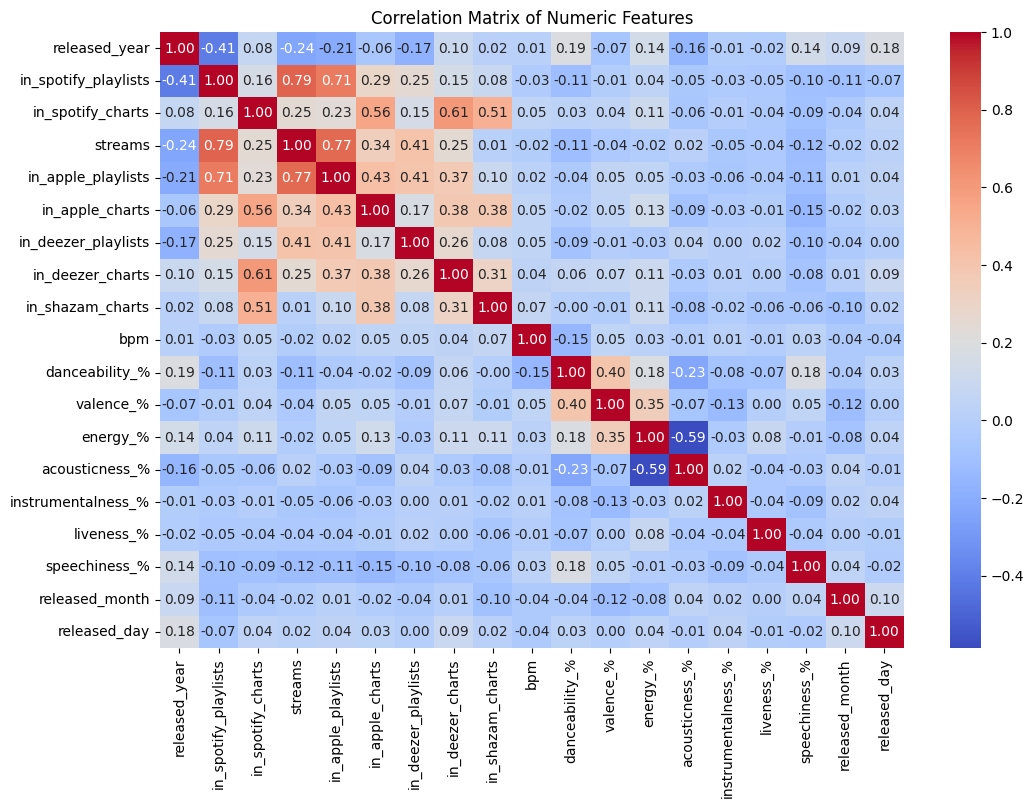

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Plotting a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Numeric Features")
plt.show()

* Data shows that songs which appear in many Spotify playlists usually
get more listens.

This might suggest that getting a song onto many playlists help it become more popular. Or the other way around. It is simply an association.

* Newer songs aren't showing up as much on Spotify playlists.

It could be due to more competition, the fact that they need more time to be discovered, or changes in how Spotify chooses songs for playlists.

* There is an inverse relation between energy % and acousticness % of a song, which is not surprising.

* Finally, the other parameters of a song don't seem to play a role in how often they are played or featured in playlists.

.

.

Getting a better picture of the release year of the songs, for example the oldest release, the newest and if there are years with no release:

In [ ]:
# Find the min and max year in the dataset
min_year = df['released_year'].min()
max_year = df['released_year'].max()

# Create a set of all years in the range
all_years = set(range(min_year, max_year + 1))

# Create a set of years present in the data
present_years = set(df['released_year'].unique())

# Find missing years
missing_years = all_years - present_years

# Function to divide a list into chunks of size n
def divide_chunks(l, n):
    # Yield successive n-sized chunks from list l
    for i in range(0, len(l), n):
        yield l[i:i + n]

# Print the years range
print("Max year: ", max_year)
print("Min year: ", min_year)

# Print the result in lines of 10
print("\nMissing years: \n")
if missing_years:
    missing_years_sorted = sorted(missing_years, reverse=True)
    chunks = list(divide_chunks(missing_years_sorted, 10))
    for chunk in chunks:
        print(chunk)
else:
    print("None")

Max year:  2023
Min year:  1942

Missing years: 

[2009, 2006, 2001, 1993, 1990, 1989, 1988, 1981, 1980, 1978]
[1977, 1976, 1974, 1972, 1969, 1967, 1966, 1965, 1964, 1962]
[1961, 1960, 1956, 1955, 1954, 1953, 1951, 1949, 1948, 1947]
[1945, 1944, 1943]


.

I saw that the most recent year is 2023 but this year is not concluded at the moment of my analysis. Let's check its latest value.

Creating a date type colum for time series anaysis:

In [ ]:
# Creating a date column
df['release_date'] = pd.to_datetime(df['released_year'].astype(str) + '-' +
                                    df['released_month'].astype(str) + '-' +
                                    df['released_day'].astype(str),
                                    errors='coerce')

In [ ]:
print("The most recently released song in the df was released on ", df['release_date'].max().date())

The most recently released song in the df was released on  2023-07-14


.

Since data for 2023 is incomplete, I will remove it. I will also cut out data before 2002.This is a personal choice for the sake of making a sample visualization. I could do many other things, like dividing the years into semesters and keeping the first 6 months of 2023, and so on.

In [ ]:
# Filter data for years between 2002 and 2022

df_filtered = df[(df['release_date'].dt.year > 2001) & (df['release_date'].dt.year < 2023)]

.

One needs also to take into account that before 2010 the data is scarce. Another option would be to focus on even more recent tracks.

In [ ]:
# Group by year and count the number of songs
df_grouped = df_filtered.groupby(df_filtered['release_date'].dt.year).size().reset_index(name='song_count')

# Rename the columns for clarity
df_grouped.columns = ['Year', 'Number of Songs']

# Create the Plotly figure
fig = px.line(df_grouped, x='Year', y='Number of Songs', title='Number of Released Songs Per Year (2002 - 2022)',
              labels={'Year': 'Year', 'Number of Songs': 'Number of Songs'})

# Customize the layout
fig.update_layout(xaxis=dict(tickmode='linear'), xaxis_title='Year', yaxis_title='Number of Songs',
                  showlegend=True)

# Show the plot
fig.show()

.

In [ ]:
# Group by year and calculate the median of 'in_spotify_playlists'
df_grouped_spotify = df_filtered.groupby(df_filtered['release_date'].dt.year)['in_spotify_playlists'].median().reset_index()

# Rename the columns for clarity
df_grouped_spotify.columns = ['Year', 'Median In Spotify Playlists']

# Create the Plotly figure for median of 'in_spotify_playlists' over time
fig = px.line(df_grouped_spotify, x='Year', y='Median In Spotify Playlists',
              title='In Spotify Playlists Median Over Time (2002 - 2022)',
              labels={'Year': 'Year', 'Median In Spotify Playlists': 'Median In Spotify Playlists'})

# Customize the layout
fig.update_layout(xaxis=dict(tickmode='linear'), xaxis_title='Year', yaxis_title='Median In Spotify Playlists',
                  showlegend=True)

# Show the plot
fig.show()

This drop in 2005 looks suspicious. Let's check the number of songs for every year in 2002-2022:

In [ ]:
by_year_in_2000 = df_filtered.groupby('released_year').size()

# Creating a list of tuples (year, number of songs)
count_of_2000 = list(by_year_in_2000.items())

count_of_2000

[(2002, 5),
 (2003, 2),
 (2004, 4),
 (2005, 1),
 (2007, 1),
 (2008, 2),
 (2010, 7),
 (2011, 7),
 (2012, 9),
 (2013, 12),
 (2014, 12),
 (2015, 11),
 (2016, 18),
 (2017, 20),
 (2018, 10),
 (2019, 32),
 (2020, 33),
 (2021, 93),
 (2022, 346)]

Here the drop we are seeing in 2005 is explained by the scarce data around those year.

The down trend could be due to the fact that newer songs have a lot of competition, or to a Pareto difference between the top songs and the rest, or changes in Spotify algorithm, and so on.

.

In [ ]:
# Interactive scatter plot for Relationship Between Streams and Spotify Playlist Inclusions
fig = px.scatter(df, x='streams', y='in_spotify_playlists', title='Relationship Between Streams and Spotify Playlist Inclusions')
fig.show()

In [ ]:
# Calculating the top artists in terms of total streams
top_artists_total = df.groupby('artist_name1')['streams'].sum().sort_values(ascending=False).head(10)

# Calculating the top artists in terms of average streams
top_artists_avg = df.groupby('artist_name1')['streams'].mean().sort_values(ascending=False).head(10)

# Create a figure with Plotly graph objects
fig = go.Figure()

# Add the first bar chart (total streams)
fig.add_trace(go.Bar(x=top_artists_total.index, y=top_artists_total, name='Total Streams'))

# Add the second bar chart (average streams) but don't display it initially
fig.add_trace(go.Bar(x=top_artists_avg.index, y=top_artists_avg, name='Average Streams', visible=False))

# Add a dropdown menu with buttons
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="down",
            showactive=True,
            buttons=list([
                dict(
                    label="Total Streams",
                    method="update",
                    args=[{"visible": [True, False]},
                          {"title": "Top 10 Artists by Total Streams"}]),
                dict(
                    label="Average Streams",
                    method="update",
                    args=[{"visible": [False, True]},
                          {"title": "Top 10 Artists by Average Streams"}])
            ]),
        )
    ],
    title="Top 10 Artists by Total Streams"
)

# Show the figure
fig.show()


In [ ]:
# Group by song name and artist name, then sum the streams
top_songs = df.groupby(['song_name', 'artist_name1'])['streams'].sum().reset_index()

# Sort the songs by total streams and select the top 10
top_songs = top_songs.sort_values(by='streams', ascending=False).head(10)


# Create the bar plot
fig = px.bar(top_songs, x='song_name', y='streams',
             hover_data=['artist_name1'],
             title='Top 10 Most Streamed Songs',
             labels={'song_name': 'Song Name', 'streams': 'Total Streams', 'artist_name1': 'Main Artist'})

# Show the plot
fig.show()